In [280]:
import regex as re
import numpy as np
import matplotlib.pyplot as plt
import highlighting_functions as hf
from importlib import reload

_ = reload(hf)

In [281]:
input_file = "input.py"

with open(input_file) as f:
    text = f.read()

print(text)

hej <- 13


In [282]:
tokens, tags = hf.tokenize(text)
print(tokens)


['hej', ' ', '<', '-', ' ', '13']


## tagging

In [283]:
print("# tokens", len(tokens))

known_default = {
    "assign": r"=|<-",
    "punct": r",;",
    "op": r"!%&/+-*:<>^",
    "brac_op": r"([{",
    "brac_cl": r")]}",
    "keyword": r"for|while|foreach|as|in|if|else|elif|and|or|not",
}


# first: tag individual tokens
tags = hf.tag_individuals(tokens, tags, known_default)

# merge and tag again to catch multiple character assignment etc.
tokens, tags = hf.merge_adjacent(tokens, tags)

print(tokens)
print(tags)
# second: context

tags = hf.tag_variables(tokens, tags)
tags = hf.tag_functions(tokens, tags)

# tokens 6
['hej', ' ', '<-', ' ', '13']
['unk', 'wsp', 'op', 'wsp', 'num']


In [284]:
for x in zip(tags, tokens):
    if x[0] == "unk":
        print("\t".join(x))

unk	hej


## features

In [285]:
feature_names = (
    "x",
    "x",
    "before_.",
    "after_.",
    "before_(",
    "before_[",
    "before_op",
    "after_op",
)

### bracket level

In [286]:
tags, brac_level = hf.bracket_levels(tags)


## comments, unknowns per line?

- many unknowns
- Starts with token not present in completely tagged lines
- comment symbol
    - not after assign
    - not inside brackets
    - NOT necessatily start of line

In [287]:
lines = []
lines_tags = []

current_line = []
current_line_tags = []
for i, token in enumerate(tokens):
    if "\n" in token:
        lines.append(current_line)
        lines_tags.append(current_line_tags)
        current_line = []
        current_line_tags = []
    else:
        current_line.append(token)
        current_line_tags.append(tags[i])

unks_per_line = [np.array(list([t == "var"] for t in L)).sum() for L in lines]
unks_per_line

[]

feature matrix (5, 8)
(0, 'x') (1, 'x') (2, 'before_.') (3, 'after_.') (4, 'before_(') (5, 'before_[') (6, 'before_op') (7, 'after_op')


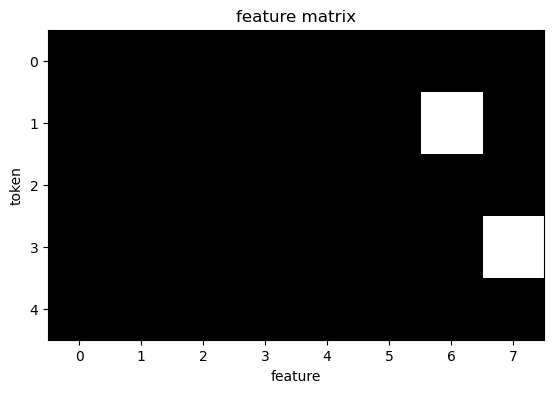

In [288]:
features = np.zeros((len(tokens), len(feature_names)))

print("feature matrix", features.shape)
print(*zip(range(len(feature_names)), feature_names))

# in brackets?
features[:, 1] = np.array(brac_level)

# before and after?
for i, token in enumerate(tokens):
    if token == ".":
        if i > 0:
            features[i - 1, 2] = 1
        if i < len(tokens) - 1:
            features[i + 1, 3] = 1

    if token == "(":
        if i > 0:
            features[i - 1, 4] = 1

    if token == "[":
        if i > 0:
            features[i - 1, 5] = 1

    if tags[i] == "op":
        if i > 0:
            features[i - 1, 6] = 1
        if i < len(tokens) - 1:
            features[i + 1, 7] = 1


plt.figure()
plt.imshow(features, cmap="gray")
plt.title("feature matrix")
plt.xlabel("feature")
plt.ylabel("token")
plt.show()

## classify

(5, 2)


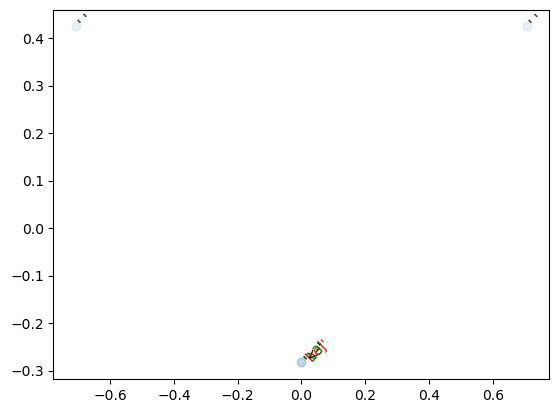

In [289]:
from sklearn.decomposition import PCA

rng = np.random.default_rng()

pca = PCA(n_components=2)

f_PCA = pca.fit_transform(features)
print(f_PCA.shape)

plt.figure()
plt.scatter(x=f_PCA[:, 0], y=f_PCA[:, 1], alpha=0.1)
for i, t in enumerate(tokens):
    c = "#000"
    if tags[i] == "unk":
        c = "r"
    elif tags[i] == "num":
        c = "g"

    plt.text(x=f_PCA[i, 0], y=f_PCA[i, 1], s=repr(t), rotation=45, color=c)

In [290]:
classes = tuple(sorted(set(tags)))
print(classes)

('num', 'op', 'unk', 'wsp')


## cleanup

In [291]:
print("# tokens/tags", len(tokens))

# Merge adjacent of same class
tokens, tags = hf.merge_adjacent(tokens, tags)

print("after merge # tokens/tags", len(tokens))
print("count unknown", sum([t == "unk" for t in tags]))

# tokens/tags 5
after merge # tokens/tags 5
count unknown 1


In [292]:
print(tokens)

['hej', ' ', '<-', ' ', '13']


In [293]:
EXCLUDE_TAGS = ("unk", "wsp")
html_text = hf.tokens_to_html(tokens, tags, EXCLUDE_TAGS)

print(html_text)

<div class="code-snippet">hej <span class="op">&lt;-</span> <span class="num">13</span></div>


## output

In [294]:
css_link = '<link rel="stylesheet" type="text/css" href="_rando_style.css">'
final_html = f"""
<head>
    {css_link}
</head>
<body>
    {html_text}
</body>
"""

with open("output.html", "w") as f:
    f.write(final_html)